## Imports
We will be using PyTorch as the main library for AI.

In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

d:\Project\face-recogtion-mlops\notebook


In [2]:
# System libraries
import os
import random
import requests
from tqdm import tqdm
from PIL import Image

# Data analytics and visualisations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchinfo import summary
from torchvision import transforms as T
from src.Utils.utils import *
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training


d:\Project\face-recogtion-mlops\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
We will be using the [DigiFace-1M Dataset](https://github.com/microsoft/DigiFace1M) for model training. This dataset contains synthesized images of people, however, with strong data augmentation, this should not be a problem (as described [here](https://microsoft.github.io/DigiFace1M/)). This dataset is [licensed](https://github.com/microsoft/DigiFace1M/blob/main/LICENSE) for non-commercial use.

### Data Download
The P1 part (5 images per identity) will be downloaded, the zip file is about 3.4 GB, so running the cell below may take a while.

In [3]:

data_dir = 'data/facenet_vn_cropped'
facenet_config_path = 'config/facenet.yaml'
facenet_config = read_config(path = facenet_config_path)
EPOCHS = facenet_config['EPOCHS']
PATIENCE = facenet_config['PATIENCE']
BATCH_SIZE = facenet_config['BATCH_SIZE']
learning_rate = facenet_config['learning_rate']
IMG_SIZE = facenet_config['IMG_SIZE']
RANDOM_SEED = facenet_config['RANDOM_SEED']
WEIGHT_DECAY = facenet_config['WEIGHT_DECAY']
LR_WARMUP = facenet_config['LR_WARMUP']
CLIP_GRAD_NORM = facenet_config['CLIP_GRAD_NORM']
PRETRAINED_MODEL = facenet_config['PRETRAINED_MODEL']
MODEL_DIR = facenet_config['MODEL_DIR']
MODEL_DIR = rename_model(model_dir = MODEL_DIR, prefix='facenet')
facenet_config['MODEL_DIR'] = MODEL_DIR
NUM_WORKERS = 0 if os.name == 'nt' else 8


In [4]:
data_dir = 'data/facenet_vn_cropped'

### Data Exploration
Our data is downloaded in the faces folder. Let's analyze the contents of the main folder.

In [5]:
print(f"Some folders: {os.listdir(data_dir)[:5]}, there are a total of {len(os.listdir(data_dir))} folders.")

Some folders: ['0', '1', '10', '100', '101'], there are a total of 916 folders.


The main folder contains many subfolders with numbers as identifiers. Let's look at one of them.

In [6]:
os.listdir(f"{data_dir}/0")

['be49e04618ab4824a7310ee560d03a24.png',
 'cfa5717f0c904d84a6027d61d68ce760.png']

As the GitHub page suggests, each folder contains five images of the same person. We can plot these images.

In [7]:
def plot_folder(path):
    # Get the image paths
    img_paths = os.listdir(path)
    
    # Plot the images
    fig, ax = plt.subplots(1, len(img_paths))
    for i, img_path in enumerate(img_paths):
        img = Image.open(path + img_path)
        ax[i].imshow(img)
        
        # Hide the ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])

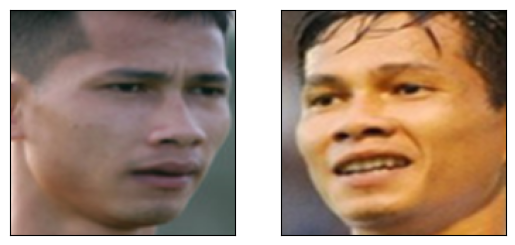

In [8]:
plot_folder(f"{data_dir}/0/")

The faces look synthetic, as they are expected to. Let's also check the shape of the pictures.

In [9]:
np.array(Image.open(f"{data_dir}/0/be49e04618ab4824a7310ee560d03a24.png")).shape

(160, 160, 3)

It appears these are 112x112 RGBA pictures. Since these are photos and the alpha value isn't needed, we will later change the picture to the standard RGB format.

### Dataset Definition
The dataset will give us a random triplet of images - an anchor image, a positive image (the same person as the anchor) and a negative image (a different person).

In [10]:
class FaceDataset(Dataset):
    def __init__(self, transform, identity_folders):
        # To later prevent data leakage between training and validation sets
        self.identity_folders = identity_folders
        self.transform = transform
        
    def __len__(self):
        return len(self.identity_folders)
    
    def get_image(self, path):
        img = Image.open(path)
        img = img.convert("RGB")
        return self.transform(img)
    
    def __getitem__(self, index):
        # The input index specifies the reference identity
        folder = self.identity_folders[index]
        img_paths = os.listdir(f"{data_dir}/{folder}/")
        
        # Anchor image is chosen from the folder
        anchor_index = random.randint(0, len(img_paths) - 1)
        anchor = self.get_image(f"{data_dir}/{folder}/{img_paths[anchor_index]}")
        
        # Positive image must be different from the anchor, but be the same identity
        positive_index = random.randint(0, len(img_paths) - 1)
        while positive_index == anchor_index:
            positive_index = random.randint(0, len(img_paths) - 1)
        positive = self.get_image(f"{data_dir}/{folder}/{img_paths[positive_index]}")
        
        # Negative image must be a different identity
        negative_folder = random.choice(self.identity_folders)
        while negative_folder == folder:
            negative_folder = random.choice(self.identity_folders)
        img_paths = os.listdir(f"{data_dir}/{negative_folder}")
        
        negative_index = random.randint(0, len(img_paths) - 1)
        negative = self.get_image(f"{data_dir}/{negative_folder}/{img_paths[negative_index]}")
        
        return anchor, positive, negative

To see a random triplet from the dataset, we need to create an instance of it. For now, we won't use data augmentation and we'll just use the `ToTensor()` transform. 

In [11]:
dataset = FaceDataset(T.ToTensor(), sorted(os.listdir(f"{data_dir}")))

In [12]:
def plot_triplet(images):
    # Plot the images
    fig, ax = plt.subplots(1, 3)
    labels = ["Anchor", "Positive", "Negative"]
    for i, img in enumerate(images):
        # The shape of the image is changed to (3, 112, 112),
        # for plotting, we need the shape to be (112, 112, 3)
        ax[i].imshow(img.permute(1, 2, 0))

        # Hide the ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        # Add a label
        ax[i].set_title(labels[i])

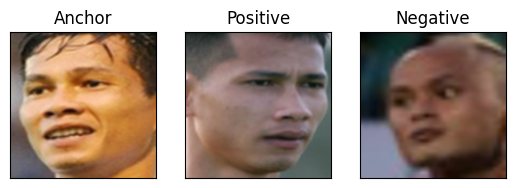

In [13]:
plot_triplet(dataset[0])

Everything is working as expected, we can now create a model.

## ModelV0 Definition
A good practice is to always start small and simple, and then slowly move to more complex models. For face recognition as a binary classification, we will need a feature extractor and a logistic function. This will together form a Siamese network. The feature extractor is inspired by VGG16 architecture (with a few tweaks, such as adding batch normalization or leaky ReLU).

We also tried using triplet loss as described in [this paper](https://arxiv.org/pdf/1503.03832.pdf), but found the binary classification approach better. Triplets are still used in training for faster convergence.

In [14]:
class SiameseModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            # Conv1, takes (3, 112, 112) input
            self.conv_block(3, 64, 3, 1, 1),
            self.conv_block(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            
            # Conv2, takes (64, 56, 56) input
            self.conv_block(64, 128, 3, 1, 1),
            self.conv_block(128, 128, 3, 1, 1),
            self.conv_block(128, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            
            # Conv3, takes (128, 28, 28) input
            self.conv_block(128, 256, 3, 1, 1),
            self.conv_block(256, 256, 3, 1, 1),
            self.conv_block(256, 256, 3, 1, 1),
            nn.MaxPool2d(2),
            
            # Conv4, takes (256, 14, 14) input
            self.conv_block(256, 512, 3, 1, 1),
            self.conv_block(512, 512, 3, 1, 1),
            self.conv_block(512, 512, 3, 1, 1),
            nn.AvgPool2d(7),
                        
            # Linear layers, takes (512, 2, 2) input, outputs 128 extracted features
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(in_features=256, out_features=128)
        )
        self.logistic = nn.Linear(in_features=128, out_features=1)
        
    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        """Creates a single conv-batchnorm-relu layer sequence."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
    
    def predict(self, x1, x2):
        output = self.forward(x1, x2)
        return torch.sigmoid(output) >= 0.5
    
    def predict_from_output(self, output):
        return torch.sigmoid(output) >= 0.5 
    
    def triplet_forward(self, a, p, n):
        a_out = self.feature_extractor(a)
        p_out = self.feature_extractor(p)
        n_out = self.feature_extractor(n)
        
        p_out = self.logistic(torch.abs(a_out - p_out))
        n_out = self.logistic(torch.abs(a_out - n_out))
        return p_out, n_out 
    
    def forward(self, x1, x2):
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        return self.logistic(torch.abs(x1 - x2))

Let's create an instance of the model and put it on the target device (cuda if available).

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# model = InceptionResnetV1(
#     classify=True,
#     pretrained=PRETRAINED_MODEL,
#     num_classes=len(os.listdir(data_dir)),
# ).to(device)


In [17]:
class ResnetTriplet(InceptionResnetV1):
    def __init__(self, pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None):
        super().__init__(pretrained, classify, num_classes, dropout_prob, device)

    def triplet_forward(self, a, p, n):
        a_out = self.forward(a)
        p_out = self.forward(p)
        n_out = self.forward(n)
        
        p_out = self.logits(torch.abs(a_out - p_out))
        n_out = self.logits(torch.abs(a_out - n_out))
        return  p_out, n_out

In [18]:
model = ResnetTriplet(
    classify=False,
    pretrained=PRETRAINED_MODEL,
    num_classes=1,
).to(device)

In [19]:
# summary(model, )

In [20]:
# torch.manual_seed(42)
# model_v0 = SiameseModelV0().to(device)
# # Show the model in detail
# summary(model_v0, ((1, 3, 160, 160), (1, 3, 160, 160)))

## Model Trainining
### Trainer
To train our model, we will first create a custom `Trainer` class. This will allow us to train any model with the same output type. Also, it contains functions to evaluate the model performance.

In [21]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = {
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            "train_val_loss": [],
            "train_val_accuracy": [],
        }
    
    def _train(self, dataloader):
        self.model.train()
        total_loss, correct = 0, 0
        for batch, (a, p, n) in tqdm(enumerate(dataloader)):
            a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)
            
            # Forward
            p_out, n_out = self.model.triplet_forward(a, p, n)

            # Loss
            loss1 = self.criterion(p_out, torch.ones_like(p_out))
            loss2 = self.criterion(n_out, torch.zeros_like(n_out))
            loss = loss1 + loss2
            
            # Metrics
            total_loss += loss
            correct += torch.sum(p_out >= 0.5) / p_out.shape[0]
            correct += torch.sum(n_out < 0.5) / n_out.shape[0]
            
            # Step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        total_loss /= len(dataloader)
        correct = correct / (2 * len(dataloader)) # Each triplet is checked twice

        return total_loss, correct
            
        
    def _val(self, dataloader):
        self.model.eval()
        total_loss, correct = 0, 0
        for batch, (a, p, n) in enumerate(dataloader):
            a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)
            
            # Forward
            with torch.inference_mode():
                p_out, n_out = self.model.triplet_forward(a, p, n)

            # Loss
            loss1 = self.criterion(p_out, torch.ones_like(p_out))
            loss2 = self.criterion(n_out, torch.zeros_like(n_out))
            loss = loss1 + loss2
            
            # Metrics
            total_loss += loss
            correct += torch.sum(p_out >= 0.5) / p_out.shape[0]
            correct += torch.sum(n_out < 0.5) / n_out.shape[0]


        total_loss /= len(dataloader)
        correct = correct / (2 * len(dataloader)) # Each triplet is checked twice
        
        return total_loss, correct

    def fit(self, epochs, save_every, train_loader, val_loader, train_val_loader=None, scheduler=None):
        """Fits the model to the given data and plots the results over epochs.
            
        Args:
            epochs (int): Number of epochs to train the model for.
            train_loader (DataLoader): Dataloader used for training.
            val_loader (DataLoader): Dataloader used for validation.
            save_every (int): The number of epochs to save a checkpoint after.
            train_val_loader (DataLoader): Dataloader used for data mismatch insights.
            scheduler (lr_scheduler): The learning rate scheduler.
        """
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}\n---------")
            self.train_for_one_epoch(train_loader, "train")
            
            if train_val_loader:
                self.validate_for_one_epoch(train_val_loader, "train_val")
            
            self.validate_for_one_epoch(val_loader, "val")

            self.save_checkpoint(epoch, save_every)

            if scheduler:
                scheduler.step()

        self.plot_metrics(train_val_loader is not None)

    def train_for_one_epoch(self, data_loader, prefix):
        loss, accuracy = self._train(data_loader)
        self.log_metrics(loss, accuracy, prefix)

    def validate_for_one_epoch(self, data_loader, prefix):
        loss, accuracy = self._val(data_loader)
        self.log_metrics(loss, accuracy, prefix)

    def log_metrics(self, loss, accuracy, prefix):
        print(f"{prefix.capitalize()}: {loss:.4f} loss, {accuracy * 100:.2f}% correct")
        self.metrics[f"{prefix}_loss"].append(loss.cpu().detach())
        self.metrics[f"{prefix}_accuracy"].append(accuracy.cpu().detach())

    def save_checkpoint(self, epoch, save_every):
        if epoch % save_every == save_every - 1:
            torch.save(self.model.state_dict(), "checkpoint.pt")

    def plot_metrics(self, has_train_val):
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        epochs = range(len(self.metrics["train_loss"]))
        self.configure_plot(ax[0], epochs, "Loss", ["train_loss", "val_loss"], ["Training", "Validation"])
        self.configure_plot(ax[1], epochs, "Accuracy", ["train_accuracy", "val_accuracy"], ["Training", "Validation"])

        if has_train_val:
            self.configure_plot(ax[0], epochs, "Loss", ["train_val_loss"], ["Train-Val"])
            self.configure_plot(ax[1], epochs, "Accuracy", ["train_val_accuracy"], ["Train-Val"])

    def configure_plot(self, ax, epochs, title, metric_keys, labels):
        for key, label in zip(metric_keys, labels):
            ax.plot(epochs, self.metrics[key], label=label)
        if title == "Loss":
            ax.legend(loc="upper right")
        else:
            ax.legend(loc="lower right")
        ax.set_title(title)

### Data Preparation
Other than just loading the data, we will augment them. Instead of splitting the dataset into training and validation sets, let's also add a train-val set, that the model is not trained on but has the same distribution as the training set. We will get:
* Training set: model is trained on, augmented
* Train-val set: model is not trained on, augmented
* Validation set: model is not trained on, not augmented

Splitting the dataset is needed to see if the model generalizes well, or if it's simply memorizing each of the examples. Also, the added set will help as see the data mismatch between the augmented and non-augmented datasets.

In [22]:
torch.manual_seed(42)
train_folders, train_val_folders, val_folders = torch.utils.data.random_split(
    sorted(os.listdir(f"{data_dir}")), [0.8, 0.1, 0.1]
)

augment = T.Compose([
    # The magnitude bins determine the strength of augmentation (max 31)
    T.TrivialAugmentWide(num_magnitude_bins=31),
    T.ToTensor(),
])

train_set = FaceDataset(augment, train_folders)
train_val_set = FaceDataset(augment, train_val_folders)
val_set = FaceDataset(T.ToTensor(), val_folders)

Let's visualize some samples from these sets.

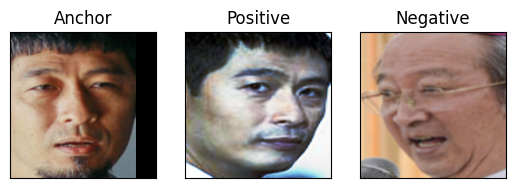

In [23]:
plot_triplet(train_set[0])

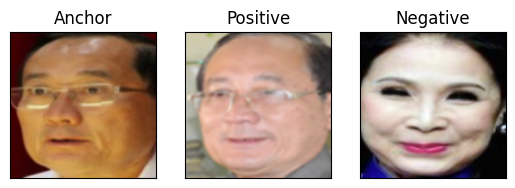

In [24]:
plot_triplet(train_val_set[0])

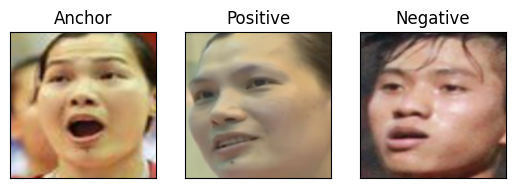

In [25]:
plot_triplet(val_set[0])

We also need to create dataloaders from the subsets. The batch size is as big as the GPU memory allows us, num_workers is set to the number of CPU cores available.

In [26]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
train_val_loader = DataLoader(train_val_set, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS)

### Training
After a few experiments, we decided to use SGD algorithm to train the network with initial learning rate of 0.1 and scheduler multiplying it by 0.3 every 5 epochs.

In [27]:
torch.manual_seed(RANDOM_SEED)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model, device, optimizer, criterion)

In [28]:
trainer.fit(
    epochs=EPOCHS,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
    scheduler=scheduler
)

Epoch 1
---------


46it [00:12,  3.82it/s]


Train: 1.3974 loss, 431290.12% correct
Train_val: 1.3974 loss, 431234.91% correct
Val: 1.3973 loss, 431136.28% correct
Epoch 2
---------


46it [00:10,  4.52it/s]


Train: 1.3974 loss, 431288.72% correct
Train_val: 1.3974 loss, 431221.38% correct
Val: 1.3973 loss, 431088.03% correct
Epoch 3
---------


46it [00:10,  4.50it/s]


Train: 1.3974 loss, 431300.50% correct
Train_val: 1.3974 loss, 431189.94% correct
Val: 1.3973 loss, 431096.00% correct
Epoch 4
---------


46it [00:09,  4.79it/s]


Train: 1.3974 loss, 431293.94% correct
Train_val: 1.3974 loss, 431344.81% correct
Val: 1.3973 loss, 431186.28% correct
Epoch 5
---------


46it [00:09,  4.78it/s]


Train: 1.3974 loss, 431279.97% correct
Train_val: 1.3974 loss, 431273.62% correct
Val: 1.3972 loss, 431145.03% correct
Epoch 6
---------


46it [00:09,  4.77it/s]


Train: 1.3973 loss, 431309.03% correct
Train_val: 1.3973 loss, 431379.69% correct
Val: 1.3972 loss, 431154.53% correct
Epoch 7
---------


46it [00:09,  4.76it/s]


Train: 1.3973 loss, 431305.41% correct
Train_val: 1.3973 loss, 431270.50% correct
Val: 1.3972 loss, 431171.62% correct
Epoch 8
---------


46it [00:09,  4.91it/s]


Train: 1.3973 loss, 431307.22% correct
Train_val: 1.3973 loss, 431335.25% correct
Val: 1.3972 loss, 431211.78% correct
Epoch 9
---------


46it [00:09,  4.94it/s]


Train: 1.3973 loss, 431331.53% correct
Train_val: 1.3973 loss, 431240.62% correct
Val: 1.3972 loss, 431110.84% correct
Epoch 10
---------


46it [00:09,  4.96it/s]


Train: 1.3973 loss, 431346.25% correct
Train_val: 1.3972 loss, 431264.59% correct
Val: 1.3971 loss, 431195.59% correct
Epoch 11
---------


46it [00:09,  4.85it/s]


Train: 1.3973 loss, 431325.72% correct
Train_val: 1.3973 loss, 431276.56% correct
Val: 1.3971 loss, 431206.25% correct
Epoch 12
---------


46it [00:09,  5.00it/s]


Train: 1.3973 loss, 431311.00% correct
Train_val: 1.3973 loss, 431248.28% correct
Val: 1.3972 loss, 431206.41% correct
Epoch 13
---------


46it [00:09,  5.07it/s]


Train: 1.3973 loss, 431335.22% correct
Train_val: 1.3973 loss, 431339.94% correct
Val: 1.3972 loss, 431139.75% correct
Epoch 14
---------


46it [00:09,  4.92it/s]


Train: 1.3973 loss, 431328.56% correct
Train_val: 1.3972 loss, 431294.62% correct
Val: 1.3971 loss, 431185.66% correct
Epoch 15
---------


5it [00:01,  4.63it/s]


KeyboardInterrupt: 

After we are done training the model, we can save it into a .pt file for later use.

In [ ]:
torch.save(model.state_dict(), "models/facenet_tune/facenet.pt")

### Error Analysis
To see how we could improve the model, we can do error analysis - finding examples that the model fails on and seeing what they have in common.

tensor([ 0,  0,  0,  ..., 15, 15, 15], device='cuda:0') tensor([ 0,  0,  0,  ..., 15, 15, 15], device='cuda:0')


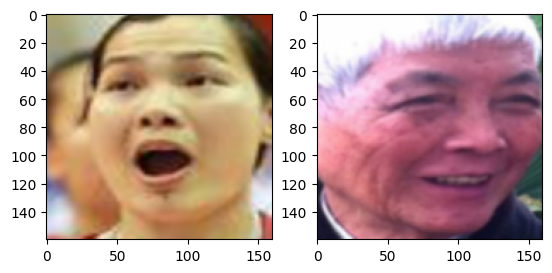

In [ ]:
# Assume model and val_loader are defined elsewhere

i, (a, p, n) = next(enumerate(val_loader))  # [random.randint(0, len(val_set) - 1)]
a, p, n = a.to(device), p.to(device), n.to(device)
model.eval()

with torch.inference_mode():
    p_out, n_out = model.triplet_forward(a, p, n)
    p_out, n_out = torch.sigmoid(p_out), torch.sigmoid(n_out)
    p_incorrect = (p_out.squeeze() < 0.5).nonzero(as_tuple=True)[0]
    n_incorrect = (n_out.squeeze() >= 0.5).nonzero(as_tuple=True)[0]

print(p_incorrect, n_incorrect)

if len(n_incorrect) > 0:
    sample_idx = n_incorrect[0].item()  # Convert tensor to Python integer
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(a[sample_idx].squeeze().permute(1, 2, 0).cpu())
    ax[1].imshow(n[sample_idx].squeeze().permute(1, 2, 0).cpu())
    plt.show()


In [ ]:
i, (a, p, n) = next(enumerate(val_loader))  # [random.randint(0, len(val_set) - 1)]
a, p, n = a.to(device), p.to(device), n.to(device)
model.eval()

with torch.inference_mode():
    p_out, n_out = model.triplet_forward(a, p, n)
    p_out, n_out = torch.sigmoid(p_out), torch.sigmoid(n_out)
    
    p_correct = (p_out.squeeze() >= 0.5).nonzero(as_tuple=True)[0]
    n_correct = (n_out.squeeze() < 0.5).nonzero(as_tuple=True)[0]

    # Find common indices where both p and n are correctly predicted
    common_correct = torch.cat([p_correct, n_correct], dim=0)
    unique_correct, counts = torch.unique(common_correct, return_counts=True)
    correct_indices = unique_correct[counts == 2]

print("Correctly predicted pairs indices:", correct_indices)

if len(correct_indices) > 0:
    sample_idx = correct_indices[0].item()  # Convert tensor to Python integer
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(a[sample_idx].squeeze().permute(1, 2, 0).cpu())
    ax[0].set_title("Anchor")
    ax[1].imshow(p[sample_idx].squeeze().permute(1, 2, 0).cpu())
    ax[1].set_title("Positive")
    ax[2].imshow(n[sample_idx].squeeze().permute(1, 2, 0).cpu())
    ax[2].set_title("Negative")
    plt.show()
else:
    print("No correctly predicted pairs found.")


Correctly predicted pairs indices: tensor([], device='cuda:0', dtype=torch.int64)
No correctly predicted pairs found.


## ModelV1
### Definition
For this model, let's try using a pre-trained model and fine-tune it to better suit our needs. In order for it to run in real time, we'll use a lightweight MobileNet V3 model. This model was trained on 224x224x3 images, but we still can feed in 112x112x3 images because of the adaptive pooling layer.

In [ ]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

In [ ]:
backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
summary(backbone, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 51.3MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [ ]:
class SiameseModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        # Load backbone ResNet
        backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        backbone.requires_grad_(False) # Freeze backbone weights

        # Replace the classifier part
        backbone.classifier = nn.Sequential(
            nn.Linear(in_features=960, out_features=256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(in_features=256, out_features=256)
        )
        
        self.feature_extractor = backbone
        
        self.logistic = nn.Linear(in_features=256, out_features=1)


    def forward(self, x):
        return self.model.forward(x)
    
    def predict(self, x1, x2):
        output = self.forward(x1, x2)
        return torch.sigmoid(output) >= 0.5
    
    def predict_from_output(self, output):
        return torch.sigmoid(output) >= 0.5 
    
    def triplet_forward(self, a, p, n):
        a_out = self.feature_extractor(a)
        p_out = self.feature_extractor(p)
        n_out = self.feature_extractor(n)
        
        p_out = self.logistic(torch.abs(a_out - p_out))
        n_out = self.logistic(torch.abs(a_out - n_out))
        return p_out, n_out 
    
    def forward(self, x1, x2):
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        return self.logistic(torch.abs(x1 - x2))

In [ ]:
torch.manual_seed(42)
model_v1 = SiameseModelV1().to(device)
# Show the model in detail
summary(model_v1, ((1, 3, 112, 112), (1, 3, 112, 112)))

Layer (type:depth-idx)                                  Output Shape              Param #
SiameseModelV1                                          [1, 1]                    --
├─MobileNetV3: 1-1                                      [1, 256]                  --
│    └─Sequential: 2-1                                  [1, 960, 4, 4]            --
│    │    └─Conv2dNormActivation: 3-1                   [1, 16, 56, 56]           (464)
│    │    └─InvertedResidual: 3-2                       [1, 16, 56, 56]           (464)
│    │    └─InvertedResidual: 3-3                       [1, 24, 28, 28]           (3,440)
│    │    └─InvertedResidual: 3-4                       [1, 24, 28, 28]           (4,440)
│    │    └─InvertedResidual: 3-5                       [1, 40, 14, 14]           (10,328)
│    │    └─InvertedResidual: 3-6                       [1, 40, 14, 14]           (20,992)
│    │    └─InvertedResidual: 3-7                       [1, 40, 14, 14]           (20,992)
│    │    └─InvertedResidu

### Training 
Since we already defined a `Trainer` class and nothing changed significantly in this model, we can go to training straight ahead. First, we will train only the head of the network.

In [ ]:
torch.manual_seed(42)
optimizer = torch.optim.SGD(model_v1.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model_v1, device, optimizer, criterion)

Epoch 1
---------


417it [02:01,  3.44it/s]

Train: 1.2308 loss, 57.66% correct


Train_val: 1.0885 loss, 68.18% correct
Val: 0.9631 loss, 72.38% correct
Epoch 2
---------


417it [02:02,  3.40it/s]

Train: 1.0083 loss, 72.25% correct


Train_val: 0.9584 loss, 75.01% correct
Val: 0.8325 loss, 79.52% correct
Epoch 3
---------


417it [02:01,  3.42it/s]

Train: 0.9271 loss, 75.88% correct


Train_val: 0.8954 loss, 77.57% correct
Val: 0.7623 loss, 82.08% correct
Epoch 4
---------


417it [02:02,  3.40it/s]

Train: 0.8916 loss, 77.33% correct


Train_val: 0.8746 loss, 77.79% correct
Val: 0.7099 loss, 83.23% correct
Epoch 5
---------


417it [02:01,  3.42it/s]

Train: 0.8663 loss, 78.18% correct


Train_val: 0.8627 loss, 77.74% correct
Val: 0.6774 loss, 83.07% correct


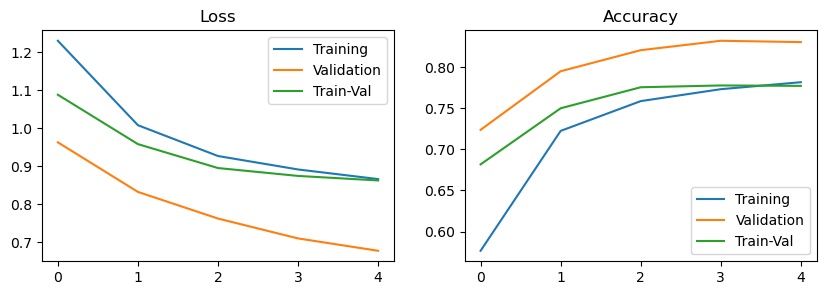

In [ ]:
trainer.fit(
    epochs=5,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
)

After this, we will train the entire network with sliced learning rate, where later layers have higher learning rate.

In [ ]:
def slice_parameters(model, start_lr, end_lr):
    sliced = []
    params_list = list(model.parameters()) # Lists from top to bottom
    start_exp = np.log2(start_lr)
    end_exp = np.log2(end_lr)
    for i, params in enumerate(params_list):
        # Exponential interpolation
        exp = start_exp * (1 - i / (len(params_list) - 1)) + end_exp * i / (len(params_list) - 1)
        lr = np.power(2, exp)
        sliced.append({'params': params, 'lr': lr})
    return sliced

In [ ]:
model_v1.requires_grad_(True)
optimizer = torch.optim.SGD(slice_parameters(model_v1, 0.01, 0.03))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model_v1, device, optimizer, criterion)

Epoch 1
---------


417it [02:16,  3.04it/s]


Train: 0.5752 loss, 87.00% correct
Train_val: 0.4611 loss, 90.08% correct
Val: 0.3296 loss, 93.74% correct
Epoch 2
---------


417it [02:18,  3.01it/s]


Train: 0.4154 loss, 91.33% correct
Train_val: 0.3718 loss, 92.28% correct
Val: 0.2585 loss, 95.28% correct
Epoch 3
---------


417it [02:21,  2.94it/s]


Train: 0.3481 loss, 93.06% correct
Train_val: 0.3361 loss, 93.20% correct
Val: 0.2309 loss, 95.79% correct
Epoch 4
---------


417it [02:22,  2.93it/s]


Train: 0.3154 loss, 93.72% correct
Train_val: 0.2847 loss, 95.09% correct
Val: 0.1895 loss, 96.98% correct
Epoch 5
---------


417it [02:21,  2.94it/s]


Train: 0.2854 loss, 94.42% correct
Train_val: 0.2853 loss, 94.49% correct
Val: 0.1676 loss, 97.17% correct
Epoch 6
---------


417it [02:21,  2.95it/s]


Train: 0.2628 loss, 94.90% correct
Train_val: 0.2532 loss, 95.27% correct
Val: 0.1474 loss, 97.54% correct
Epoch 7
---------


417it [02:21,  2.95it/s]


Train: 0.2628 loss, 94.94% correct
Train_val: 0.2538 loss, 95.30% correct
Val: 0.1520 loss, 97.42% correct
Epoch 8
---------


417it [02:22,  2.93it/s]


Train: 0.2542 loss, 95.16% correct
Train_val: 0.2695 loss, 94.67% correct
Val: 0.1468 loss, 97.70% correct
Epoch 9
---------


417it [02:21,  2.94it/s]


Train: 0.2498 loss, 95.29% correct
Train_val: 0.2413 loss, 95.49% correct
Val: 0.1519 loss, 97.60% correct
Epoch 10
---------


417it [02:21,  2.94it/s]


Train: 0.2402 loss, 95.51% correct
Train_val: 0.2415 loss, 95.42% correct
Val: 0.1384 loss, 98.00% correct
Epoch 11
---------


417it [02:22,  2.92it/s]


Train: 0.2419 loss, 95.35% correct
Train_val: 0.2411 loss, 95.27% correct
Val: 0.1413 loss, 97.73% correct
Epoch 12
---------


417it [02:23,  2.90it/s]


Train: 0.2366 loss, 95.50% correct
Train_val: 0.2454 loss, 95.22% correct
Val: 0.1435 loss, 97.80% correct
Epoch 13
---------


417it [02:22,  2.92it/s]


Train: 0.2406 loss, 95.38% correct
Train_val: 0.2367 loss, 95.58% correct
Val: 0.1361 loss, 98.00% correct
Epoch 14
---------


417it [02:21,  2.94it/s]


Train: 0.2439 loss, 95.40% correct
Train_val: 0.2418 loss, 95.59% correct
Val: 0.1433 loss, 97.60% correct
Epoch 15
---------


417it [02:23,  2.91it/s]


Train: 0.2386 loss, 95.52% correct
Train_val: 0.2488 loss, 95.17% correct
Val: 0.1468 loss, 97.76% correct
Epoch 16
---------


417it [02:22,  2.93it/s]


Train: 0.2373 loss, 95.48% correct
Train_val: 0.2484 loss, 95.22% correct
Val: 0.1351 loss, 97.86% correct
Epoch 17
---------


417it [02:21,  2.94it/s]


Train: 0.2445 loss, 95.25% correct
Train_val: 0.2346 loss, 95.55% correct
Val: 0.1353 loss, 97.77% correct
Epoch 18
---------


417it [02:21,  2.96it/s]


Train: 0.2425 loss, 95.29% correct
Train_val: 0.2310 loss, 95.67% correct
Val: 0.1490 loss, 97.69% correct
Epoch 19
---------


417it [02:20,  2.96it/s]


Train: 0.2424 loss, 95.41% correct
Train_val: 0.2343 loss, 95.63% correct
Val: 0.1387 loss, 97.88% correct
Epoch 20
---------


417it [02:22,  2.92it/s]


Train: 0.2374 loss, 95.51% correct
Train_val: 0.2464 loss, 95.14% correct
Val: 0.1428 loss, 97.82% correct


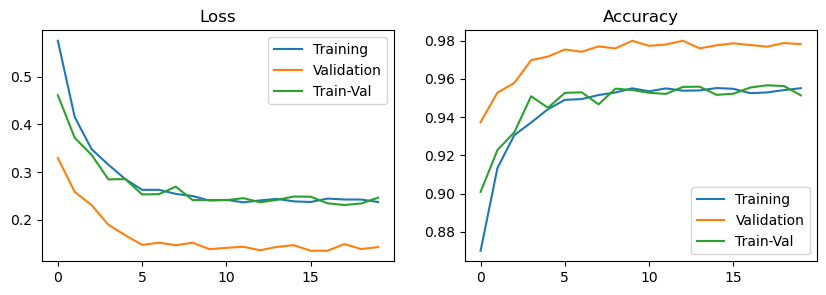

In [ ]:
trainer.fit(
    epochs=20,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
    scheduler=scheduler
)

In [ ]:
torch.save(model_v1.state_dict(), "model_v1.pt")

## Model usage
The model as is can verify if two images of a person are of the same identity. It takes in a reference image and a live image. For face recognition, we need to create a dataset of reference images, precompute the results of the feature extractor for each image, and store them for later use. When a live image is taken, we calculate the features of the live image and use them as an input to logistic regression together with one of the reference images to determine, whether these images are of the same person or not. After going through all of the reference images, the model should predict one true result corresponding to the real person, or no true result if the person is not in the reference database.

## References
Bae, G., de La Gorce, M., Baltrušaitis, T., Hewitt, C., Chen, D., Valentin, J., Cipolla, R., & Shen, J. (2023). DigiFace-1M: 1 Million Digital Face Images for Face Recognition. In 2023 IEEE Winter Conference on Applications of Computer Vision (WACV). IEEE. https://github.com/microsoft/DigiFace1M

Schroff, F., Kalenichenko, D., & Philbin, J. (2015). FaceNet: A unified embedding for face recognition and clustering. In 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). https://arxiv.org/pdf/1503.03832.pdf


Koch, G., Zemel, R., & Salakhutdinov, R. (2015). Siamese Neural Networks for One-shot Image Recognition. In Proceedings of the 2015 Conference on Neural Information Processing Systems (NIPS). https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf


Simonyan, K., & Zisserman, A. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv preprint https://arxiv.org/pdf/1409.1556.pdf


Howard, A., Sandler, M., Chu, G., Chen, L.-C., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q. V., & Adam, H. (2019). Searching for MobileNetV3. arXiv preprint https://arxiv.org/pdf/1905.02244.pdf.